In [ ]:
#!kill -9 -1

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.2.0-rc1'

## Get tars and import

In [ ]:
#Dlib predictor download
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2 && rm -r shape_predictor_68_face_landmarks.dat.bz2

--2020-03-28 11:37:22--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  18.1MB/s    in 4.9s    

2020-03-28 11:37:32 (12.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

rm: cannot remove 'shape_predictor_68_face_landmarks.dat.bz2': No such file or directory


In [ ]:
!pip install scikit-video

     |████████████████████████████████| 2.3MB 41kB/s 


In [ ]:
import numpy as np
import cv2
import dlib
import math
import sys
import pickle
import argparse
import os
import skvideo.io

In [ ]:
#!mv s1/video/mpg_6000/ mpg_6000/
#!mv s1/video/ video/

## Grid Videos Preprocess

In [ ]:
!wget http://spandh.dcs.shef.ac.uk/gridcorpus/s1/video/s1.mpg_vcd.zip
!unzip s1.mpg_vcd.zip.1 && rm -r s1.mpg_vcd.zip.1

--2020-03-28 11:37:56--  http://spandh.dcs.shef.ac.uk/gridcorpus/s1/video/s1.mpg_vcd.zip
Resolving spandh.dcs.shef.ac.uk (spandh.dcs.shef.ac.uk)... 143.167.8.2
Connecting to spandh.dcs.shef.ac.uk (spandh.dcs.shef.ac.uk)|143.167.8.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 422746353 (403M) [application/zip]
Saving to: ‘s1.mpg_vcd.zip’

s1.mpg_vcd.zip      100%[===================>] 403.16M  45.9MB/s    in 9.8s    

2020-03-28 11:38:06 (41.2 MB/s) - ‘s1.mpg_vcd.zip’ saved [422746353/422746353]

unzip:  cannot find or open s1.mpg_vcd.zip.1, s1.mpg_vcd.zip.1.zip or s1.mpg_vcd.zip.1.ZIP.


In [ ]:
video_dir='s1/'
videos = [video_dir + i for i in os.listdir(video_dir)]
videos=sorted(videos)

In [ ]:
videos.remove('s1/Thumbs.db')

In [ ]:
name_list=list(set(list(map(lambda x: x[3:5],videos))))

In [ ]:
dummy_videos=list(map(lambda x: x[3:5],videos))

In [ ]:
index_list=[dummy_videos.index(n) for n in name_list]

In [ ]:
index_list.sort()

In [ ]:
index_list

[0, 58, 122, 180, 240, 304, 362, 426, 488, 552, 616, 680, 744, 808, 872, 936]

In [ ]:
a=np.asarray(videos)
videos=list(a[index_list])

In [ ]:
videos

['s1/bbaf2n.mpg',
 's1/bgaa6n.mpg',
 's1/braf8n.mpg',
 's1/bwaa1s.mpg',
 's1/lbad6n.mpg',
 's1/lgaf4n.mpg',
 's1/lrae2n.mpg',
 's1/lwae8n.mpg',
 's1/pbac1s.mpg',
 's1/pgad8n.mpg',
 's1/prac6n.mpg',
 's1/pwad2n.mpg',
 's1/sbaa4n.mpg',
 's1/sgac2n.mpg',
 's1/srab1s.mpg',
 's1/swab6n.mpg']

In [ ]:
#dataset = tf.data.Dataset.from_tensor_slices((videos[:10]))
#dataset = dataset.shuffle(10)
#dataset = dataset.map(make_mouth_crops, num_parallel_calls=4)

In [ ]:
#videos = ['id23_vcd_priazn.mpg', 'id2_vcd_swwp2s.mpg']

## Dlib and lip extract function

In [1]:
# Dlib requirements.
predictor_path = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
width_crop_max = 100
height_crop_max = 50

In [ ]:
def make_mouth_crops(video):
  global width_crop_max,height_crop_max,video_pad

  inputparameters = {}
  outputparameters = {}
  reader = skvideo.io.FFmpegReader(video, inputdict=inputparameters, outputdict=outputparameters)
  video_shape = reader.getShape()
  (num_frames, h, w, c) = video_shape

  max_counter = 150
  total_num_frames = int(video_shape[0])
  num_frames = min(total_num_frames,max_counter)
  counter = 0

  out_frame=[]



  # Loop over all frames.
  for frame in reader.nextFrame():
    #print('frame_shape:', frame.shape)
    # Process the video and extract the frames up to a certain number and then stop processing.
    #if counter > num_frames:
      #break
    # Detection of the frame
    detections = detector(frame, 1)
    # 20 mark for mouth
    marks = np.zeros((2, 20))
    # All unnormalized face features.

    Features_Abnormal = np.zeros((190, 1))

    # If the face is detected.
    #print(len(detections))

    if len(detections) > 0:
      # Shape of the face.
      shape = predictor(frame, detections[0]) #single face considered 
      co = 0
      # Specific for the mouth.
      for ii in range(48, 68):
        """
        This for loop is going over all mouth-related features.
        X and Y coordinates are extracted and stored separately.
        """
        X = shape.part(ii)
        A = (X.x, X.y)
        marks[0, co] = X.x
        marks[1, co] = X.y
        co += 1

      # Get the extreme points(top-left & bottom-right)
      X_left, Y_left, X_right, Y_right = [int(np.amin(marks, axis=1)[0]), int(np.amin(marks, axis=1)[1]),
                                          int(np.amax(marks, axis=1)[0]),
                                          int(np.amax(marks, axis=1)[1])]
      # Find the center of the mouth.
      X_center = (X_left + X_right) / 2.0
      Y_center = (Y_left + Y_right) / 2.0

      # Make a boarder for cropping.
      border = 15
      X_left_new = X_left - border
      Y_left_new = Y_left - border
      X_right_new = X_right + border
      Y_right_new = Y_right + border

      # Width and height for cropping(before and after considering the border).
      width_new = X_right_new - X_left_new
      height_new = Y_right_new - Y_left_new
      width_current = X_right - X_left
      height_current = Y_right - Y_left


      # Determine the cropping rectangle dimensions(the main purpose is to have a fixed area).
      if width_crop_max == 0 and height_crop_max == 0:
        width_crop_max = width_new
        height_crop_max = height_new
      else:
        width_crop_max += 1.5 * np.maximum(width_current - width_crop_max, 0)
        height_crop_max += 1.5 * np.maximum(height_current - height_crop_max, 0)

      # # # Uncomment if the lip area is desired to be rectangular # # # #
      #########################################################
      # Find the cropping points(top-left and bottom-right).
      X_left_crop = int(X_center - width_crop_max / 2.0)
      X_right_crop = int(X_center + width_crop_max / 2.0)
      Y_left_crop = int(Y_center - height_crop_max / 2.0)
      Y_right_crop = int(Y_center + height_crop_max / 2.0)



      if X_left_crop >= 0 and Y_left_crop >= 0 and X_right_crop < w and Y_right_crop < h:
        mouth = frame[Y_left_crop:Y_right_crop, X_left_crop:X_right_crop, :]
        #cv2.imwrite(mouth_destination_path + '/' + 'frame' + '_' + str(counter) + '.png', mouth)
        out_frame.append(mouth.T)

      else:
        cv2.putText(frame, 'NA. ', (30, 30), font, 1, (0, 255, 255), 2) #Check in LRS

    else:
      #cv2.putText(frame, 'NA. ', (30, 30), font, 1, (0, 0, 255), 2)#Check in LRS
      out_frame.append(mouth.T)
    counter += 1


  out_frame=np.asarray(out_frame).reshape(-1,100,50,3)
  print("Original shape : ",out_frame.shape)
  if out_frame.shape[0]<video_pad:
    pad_array=np.zeros((video_pad-out_frame.shape[0],100,50,3))
    out_frame=np.concatenate((out_frame, pad_array), axis=0)
  #out_frame=(out_frame.astype('float32'))/255

  return out_frame

## LRS Get files

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
!cp -r '/gdrive/My Drive/Hello Attention/Practice 3/Dataset/0af00UcTOSc/' '/content/lrs1'

cp: cannot open '/gdrive/My Drive/Hello Attention/Practice 3/Dataset/0af00UcTOSc/00001.gdoc' for reading: Operation not supported
cp: cannot open '/gdrive/My Drive/Hello Attention/Practice 3/Dataset/0af00UcTOSc/00003.gdoc' for reading: Operation not supported


In [ ]:
out_dir='lrs1/'
text_files = [out_dir + i for i in os.listdir(out_dir) if i.endswith(".txt")]
video_files = [out_dir + i for i in os.listdir(out_dir) if i.endswith(".mp4")]

In [ ]:
text_files=sorted(text_files)
video_files=sorted(video_files)
print(video_files)

['lrs1/00001.mp4', 'lrs1/00002.mp4', 'lrs1/00003.mp4', 'lrs1/00004.mp4', 'lrs1/00005.mp4', 'lrs1/00006.mp4', 'lrs1/00007.mp4', 'lrs1/00008.mp4', 'lrs1/00009.mp4', 'lrs1/00010.mp4', 'lrs1/00011.mp4', 'lrs1/00012.mp4', 'lrs1/00013.mp4', 'lrs1/00014.mp4', 'lrs1/00015.mp4', 'lrs1/00016.mp4', 'lrs1/00017.mp4', 'lrs1/00018.mp4', 'lrs1/00019.mp4', 'lrs1/00020.mp4', 'lrs1/00021.mp4', 'lrs1/00022.mp4', 'lrs1/00023.mp4', 'lrs1/00024.mp4', 'lrs1/00025.mp4', 'lrs1/00027.mp4', 'lrs1/00028.mp4', 'lrs1/00029.mp4', 'lrs1/00030.mp4', 'lrs1/00031.mp4', 'lrs1/00032.mp4', 'lrs1/00033.mp4', 'lrs1/00034.mp4', 'lrs1/00035.mp4', 'lrs1/00036.mp4', 'lrs1/00037.mp4', 'lrs1/00038.mp4', 'lrs1/00039.mp4', 'lrs1/00040.mp4', 'lrs1/00041.mp4', 'lrs1/00042.mp4', 'lrs1/00043.mp4', 'lrs1/00044.mp4', 'lrs1/00045.mp4', 'lrs1/00046.mp4', 'lrs1/00047.mp4', 'lrs1/00048.mp4', 'lrs1/00049.mp4', 'lrs1/00050.mp4', 'lrs1/00051.mp4', 'lrs1/00052.mp4', 'lrs1/00053.mp4', 'lrs1/00054.mp4', 'lrs1/00055.mp4', 'lrs1/00056.mp4']


In [ ]:
#videos=[video_files[0],video_files[1],video_files[2],video_files[3],video_files[4]]
#videos_train = video_files[:49]
#videos_test = video_files[49:56]
#print(videos_train)
#print(videos_test)

['lrs1/00001.mp4', 'lrs1/00002.mp4', 'lrs1/00003.mp4', 'lrs1/00004.mp4', 'lrs1/00005.mp4', 'lrs1/00006.mp4', 'lrs1/00007.mp4', 'lrs1/00008.mp4', 'lrs1/00009.mp4', 'lrs1/00010.mp4', 'lrs1/00011.mp4', 'lrs1/00012.mp4', 'lrs1/00013.mp4', 'lrs1/00014.mp4', 'lrs1/00015.mp4', 'lrs1/00016.mp4', 'lrs1/00017.mp4', 'lrs1/00018.mp4', 'lrs1/00019.mp4', 'lrs1/00020.mp4', 'lrs1/00021.mp4', 'lrs1/00022.mp4', 'lrs1/00023.mp4', 'lrs1/00024.mp4', 'lrs1/00025.mp4', 'lrs1/00027.mp4', 'lrs1/00028.mp4', 'lrs1/00029.mp4', 'lrs1/00030.mp4', 'lrs1/00031.mp4', 'lrs1/00032.mp4', 'lrs1/00033.mp4', 'lrs1/00034.mp4', 'lrs1/00035.mp4', 'lrs1/00036.mp4', 'lrs1/00037.mp4', 'lrs1/00038.mp4', 'lrs1/00039.mp4', 'lrs1/00040.mp4', 'lrs1/00041.mp4', 'lrs1/00042.mp4', 'lrs1/00043.mp4', 'lrs1/00044.mp4', 'lrs1/00045.mp4', 'lrs1/00046.mp4', 'lrs1/00047.mp4', 'lrs1/00048.mp4', 'lrs1/00049.mp4', 'lrs1/00050.mp4']
['lrs1/00051.mp4', 'lrs1/00052.mp4', 'lrs1/00053.mp4', 'lrs1/00054.mp4', 'lrs1/00055.mp4', 'lrs1/00056.mp4']


In [ ]:
frame_numbers=[]
for i in range(len(video_files)):
  reader = skvideo.io.FFmpegReader(video_files[i])
  (num_frames, h, w, c) = reader.getShape()
  frame_numbers.append(num_frames)
video_pad=max(frame_numbers)
print(max(frame_numbers))

320


## Preprocess Videos

In [ ]:
X_train=[]
for i,v in enumerate(video_files):
  #if i>2:
    #break
  print("Video ",i," : ",end="")
  out_frame=make_mouth_crops(v)
  X_train.append(out_frame)
  print("Appended Video shape : ",out_frame.shape)

Video  0  : Original shape :  (137, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  1  : Original shape :  (204, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  2  : Original shape :  (157, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  3  : Original shape :  (102, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  4  : Original shape :  (151, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  5  : Original shape :  (193, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  6  : Original shape :  (243, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  7  : Original shape :  (152, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  8  : Original shape :  (168, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  9  : Original shape :  (137, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  10  : Original shape :  (100, 100, 50, 3)
Appended Video shape :  (320, 100, 50, 3)
Video  11

In [ ]:
X_train = np.asarray(X_train)
X_train = X_train.astype('float32')
X_train /= 255

## Test

In [ ]:
# Required parameters for mouth extraction.
width_crop_max = 100
height_crop_max = 50

mouth_destination_path = 'mouth'
if not os.path.exists(mouth_destination_path):
    os.makedirs(mouth_destination_path)

reader = skvideo.io.FFmpegReader(video_files[0]) #Change here ADD NAME INPUT VIDEO
video_shape = reader.getShape()
(num_frames, h, w, c) = video_shape
print(num_frames, h, w, c)

# The required parameters
activation = []
max_counter = 150
total_num_frames = int(video_shape[0])
num_frames = total_num_frames
counter = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# Define the writer
writer = skvideo.io.FFmpegWriter('mouth/output.mp4')


for frame in reader.nextFrame():
  #print('frame_shape:', frame.shape)
  # Process the video and extract the frames up to a certain number and then stop processing.
  #if counter > num_frames:
    #break
  # Detection of the frame
  detections = detector(frame, 1)
  # 20 mark for mouth
  marks = np.zeros((2, 20))
  # All unnormalized face features.
  
  Features_Abnormal = np.zeros((190, 1))
  
  # If the face is detected.
  print("Detected",len(detections))
  
  if len(detections) > 0:
    # Shape of the face.
    shape = predictor(frame, detections[0]) #single face considered 
    co = 0
    # Specific for the mouth.
    for ii in range(48, 68):
      """
      This for loop is going over all mouth-related features.
      X and Y coordinates are extracted and stored separately.
      """
      X = shape.part(ii)
      A = (X.x, X.y)
      marks[0, co] = X.x
      marks[1, co] = X.y
      co += 1
      
    # Get the extreme points(top-left & bottom-right)
    X_left, Y_left, X_right, Y_right = [int(np.amin(marks, axis=1)[0]), int(np.amin(marks, axis=1)[1]),
                                        int(np.amax(marks, axis=1)[0]),
                                        int(np.amax(marks, axis=1)[1])]
    # Find the center of the mouth.
    X_center = (X_left + X_right) / 2.0
    Y_center = (Y_left + Y_right) / 2.0
    print("Coordinates: ",X_left, Y_left, X_right, Y_right)
    print("Center: ",X_center,Y_center)
    # Make a boarder for cropping.
    border = 15
    X_left_new = X_left - border
    Y_left_new = Y_left - border
    X_right_new = X_right + border
    Y_right_new = Y_right + border

    # Width and height for cropping(before and after considering the border).
    width_new = X_right_new - X_left_new
    height_new = Y_right_new - Y_left_new
    width_current = X_right - X_left
    height_current = Y_right - Y_left


    # Determine the cropping rectangle dimensions(the main purpose is to have a fixed area).
    if width_crop_max == 0 and height_crop_max == 0:
      width_crop_max = width_new
      height_crop_max = height_new
    else:
      width_crop_max += 1.5 * np.maximum(width_current - width_crop_max, 0)
      height_crop_max += 1.5 * np.maximum(height_current - height_crop_max, 0)
      
    # # # Uncomment if the lip area is desired to be rectangular # # # #
    #########################################################
    # Find the cropping points(top-left and bottom-right).
    X_left_crop = int(X_center - width_crop_max / 2.0)
    X_right_crop = int(X_center + width_crop_max / 2.0)
    Y_left_crop = int(Y_center - height_crop_max / 2.0)
    Y_right_crop = int(Y_center + height_crop_max / 2.0)
    #########################################################

    # # # # # Uncomment if the lip area is desired to be rectangular # # # #
    # #######################################
    # # Use this part if the cropped area should look like a square.
    #crop_length_max = max(width_crop_max, height_crop_max) / 2
    #
    # # Find the cropping points(top-left and bottom-right).

    #X_left_crop = int(X_center - crop_length_max)
    #X_right_crop = int(X_center + crop_length_max)
    #Y_left_crop = int(Y_center - crop_length_max)
    #Y_right_crop = int(Y_center + crop_length_max)
    #########################################

    if X_left_crop >= 0 and Y_left_crop >= 0 and X_right_crop < w and Y_right_crop < h:
      mouth = frame[Y_left_crop:Y_right_crop, X_left_crop:X_right_crop, :]
      # Save the mouth area.
      #mouth_gray = cv2.cvtColor(mouth, cv2.COLOR_RGB2GRAY)
      cv2.imwrite(mouth_destination_path + '/' + 'frame' + '_' + str(counter) + '.png', mouth)
      
      activation.append(1)
    else:
      cv2.putText(frame, 'The full mouth is not detectable. ', (30, 30), font, 1, (0, 255, 255), 2)
      print("No activation")
      activation.append(0)

  else:
    cv2.putText(frame, 'No Face', (30, 30), font, 1, (0, 0, 255), 2)
    print("No Face for frame ",counter)
    activation.append(0)
    #mouth = frame[Y_center-25: Y_center+25, X_center-50: X_center+50,:]
    cv2.imwrite(mouth_destination_path + '/' + 'frame' + '_' + str(counter) + '.png', mouth)

  if activation[counter] == 1:
    # Demonstration of face.
    cv2.rectangle(frame, (X_left_crop, Y_left_crop), (X_right_crop, Y_right_crop), (0, 255, 0), 2)
    # cv2.imshow('frame', frame)
    print('frame number %d of %d' % (counter, num_frames))

    # write the output frame to file
  print("writing frame %d with activation %d" % (counter + 1, activation[counter]))
  writer.writeFrame(frame) 
  
  counter += 1

writer.close()

#Text

## Grid Text Get Files

In [ ]:
!wget http://spandh.dcs.shef.ac.uk/gridcorpus/s1/align/s1.tar
!tar -xvf s1.tar && rm -r s1.tar

In [ ]:
#files=['swwp2s.align','priazn.align']
def prep_text(files):
  sent=[]
  for file in files:
    f = open(file, "r")
    dummy=[line.split()[-1] for line in f] #-1 coz that's the word we want, 0 and 1 have timestamps
    dummy[0]='<start>'
    dummy[-1]='<end>'
    sent.append(dummy)
  return sent

In [ ]:
text_dir='align/'
files = [text_dir + i for i in os.listdir(text_dir)]
files=sorted(files)

In [ ]:
sent = prep_text(files)

In [ ]:
b=np.array(sent)
sent=list(b[index_list])

In [ ]:
sent

[['<start>', 'bin', 'blue', 'at', 'f', 'two', 'now', '<end>'],
 ['<start>', 'bin', 'green', 'at', 'a', 'six', 'now', '<end>'],
 ['<start>', 'bin', 'red', 'at', 'f', 'eight', 'now', '<end>'],
 ['<start>', 'bin', 'white', 'at', 'a', 'one', 'soon', '<end>'],
 ['<start>', 'lay', 'blue', 'at', 'd', 'six', 'now', '<end>'],
 ['<start>', 'lay', 'green', 'at', 'f', 'four', 'now', '<end>'],
 ['<start>', 'lay', 'red', 'at', 'e', 'two', 'now', '<end>'],
 ['<start>', 'lay', 'white', 'at', 'e', 'eight', 'now', '<end>'],
 ['<start>', 'place', 'blue', 'at', 'c', 'one', 'soon', '<end>'],
 ['<start>', 'place', 'green', 'at', 'd', 'eight', 'now', '<end>'],
 ['<start>', 'place', 'red', 'at', 'c', 'six', 'now', '<end>'],
 ['<start>', 'place', 'white', 'at', 'd', 'two', 'now', '<end>'],
 ['<start>', 'set', 'blue', 'at', 'a', 'four', 'now', '<end>'],
 ['<start>', 'set', 'green', 'at', 'c', 'two', 'now', '<end>'],
 ['<start>', 'set', 'red', 'at', 'b', 'one', 'soon', '<end>'],
 ['<start>', 'set', 'white', 'at'

## LRS Text Preprocess

In [ ]:
#texts=[text_files[0],text_files[1],text_files[2],text_files[3],text_files[4], text_files[7]] #, text_files[7]
def prep_text(files):
  sent=[]
  for file in files:
    dummy=[]
    f = open(file, "r")
    for line in f:
      dummy.extend(line.split())

    index_conf=dummy.index('Conf:')
    dummy=dummy[:index_conf+1]
    dummy[0]='<start>'
    dummy[-1]='<end>'
    print(dummy)
    sent.append(dummy)
  return sent

In [ ]:
sent=prep_text(text_files)

['<start>', 'TO', 'SHOW', 'IT', 'TO', 'YOU', 'NOT', 'BECAUSE', 'I', 'WANT', 'TO', 'GIVE', 'YOU', 'THE', 'KIND', 'OF', 'STARBUCKS', 'TOUR', 'OF', 'HISTORIC', 'ENGLAND', 'BUT', '<end>']
['<start>', 'BEFORE', 'THE', 'SPREAD', 'OF', 'COFFEE', 'AND', 'TEA', 'THROUGH', 'BRITISH', 'CULTURE', 'WHAT', 'PEOPLE', 'DRANK', 'BOTH', 'ELITE', 'AND', 'MASS', 'FOLKS', 'DRANK', '<end>']
['<start>', 'DRINKING', 'ALL', 'DAY', 'AND', 'THEN', 'YOU', 'SWITCHED', 'FROM', 'A', 'DEPRESSANT', 'TO', 'A', 'STIMULANT', 'IN', 'YOUR', '<end>']
['<start>', 'WHERE', 'PEOPLE', 'WOULD', 'GET', 'TOGETHER', 'FROM', 'DIFFERENT', 'BACKGROUNDS', 'DIFFERENT', 'FIELDS', 'OF', 'EXPERTISE', '<end>']
['<start>', 'IT', 'WAS', 'A', 'SPACE', 'AS', 'MATT', 'RIDLEY', 'TALKED', 'ABOUT', 'WHERE', 'IDEAS', 'COULD', 'HAVE', 'SEX', 'THIS', 'WAS', 'THEIR', 'CONJUGAL', 'BED', 'IN', 'A', '<end>']
['<start>', 'SPENDING', 'A', 'LOT', 'OF', 'TIME', 'THINKING', 'ABOUT', 'COFFEEHOUSES', 'FOR', 'THE', 'LAST', 'FIVE', 'YEARS', 'BECAUSE', "I'VE", 'BEE

## Prep Text

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [ ]:
tokenizer = Tokenizer(oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(sent)
tokenizer.word_index['<pad>'] = 0


In [ ]:
sseq = tokenizer.texts_to_sequences(sent)
#sseq

In [ ]:
decoder_input_data=pad_sequences(sseq, padding='post')

In [ ]:
#decoder_input_data=decoder_input_data.astype('float32')

#Trash

In [ ]:
import numpy as np
import cv2

In [ ]:
import os
out_dir='output/'
mouths = [out_dir + i+'/' for i in os.listdir(out_dir)]


In [ ]:
mouths

['output/mouth1/', 'output/mouth0/']

In [ ]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count,3,100,50), dtype = np.uint8)
    
    for i, image_file in enumerate(images):
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        print(image.shape)
        #image = image.reshape(50,100,3)
        #print(image.shape)
        data[i] = image.T
        
        #if i % 1 == 0:
            #print ('Processed {} of {}'.format(i, count))
            
    return data

In [ ]:
np.append([[1, 2, 3], [4, 5, 6]], [[7, 8, 9]], axis=0)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [ ]:
v=[1]
v.append(2)

In [ ]:
v

[1, 2]

In [ ]:
X_train=[]
for i,mouth in enumerate(mouths):
  print(i)
  print(mouth)
  train_images = [mouth + i for i in os.listdir(mouth)]
  train = prep_data(train_images)
  train=train.reshape(-1,100,50,3)
  #train=np.expand_dims(train,0)
  
  X_train.append(train)
  
X_train = np.asarray(X_train)
X_train = X_train.astype('float32')
X_train /= 255
#X_train=np.array(X_train)

In [ ]:
import os
TRAIN_DIR='output/mouth/'
train_images = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)]

TRAIN_DIR1='output/mouth1/'
train_images1 = [TRAIN_DIR1 + i for i in os.listdir(TRAIN_DIR1)]




  

train1= prep_data(train_images1)


train1=train1.reshape(-1,100,50,3)


train1=np.expand_dims(train1,0)
train=np.concatenate((train,train1))



In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

files=['swwp2s.align','priazn.align']
def prep_text(files):
  sent=[]
  for file in files:
    f = open(file, "r")
    dummy=[line.split()[-1] for line in f] #-1 coz that's the word we want, 0 and 1 have timestamps
    #print(dummy)
    dummy[0]='<start>'
    dummy[-1]='<end>'
    sent.append(dummy)
  return sent

sent=prep_text(files)
tokenizer= tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(sent)
sseq = tokenizer.texts_to_sequences(sent)
dec_input=np.asarray(sseq)
decoder_input_data=dec_input.astype('int32')
"""
decoder_target_data=np.zeros((dec_input.shape[0], dec_input.shape[1], len(tokenizer.word_index)+1),dtype='float32')
for i,line in enumerate(sent):
  for t, word in enumerate(line):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    if t > 0:
      #print(i,line)
      #print(t,word)
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t - 1, tokenizer.word_index[word]] = 1.
      #print(decoder_target_data)
"""

In [ ]:
len(decoder_input_data)

2

In [ ]:
tokenizer.word_index['<pad>'] = 0

In [ ]:
len(tokenizer.word_index)

16

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, decoder_input_data))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)   #1

In [ ]:
dataset

<DatasetV1Adapter shapes: ((2, 75, 100, 50, 3), (2, 8)), types: (tf.float32, tf.int32)>

# Model

## Make dataset

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
max_length(sent)

54

In [ ]:
BATCH_SIZE = 2
BUFFER_SIZE = len(X_train)
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 50
units = 256
vocab_size = len(tokenizer.word_index)
max_length_targ=max_length(sent)-2

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, decoder_input_data)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## Make Model

In [ ]:
def gru(units):
  # If you have a GPU, we recommend using the CuDNNGRU layer (it provides a 
  # significant speedup).
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [ ]:
def lstm(units):
  # If you have a GPU, we recommend using the CuDNNGRU layer (it provides a 
  # significant speedup).
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNLSTM(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.LSTM(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [ ]:
class Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self,enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        # shape after fc == (batch_size, 64, embedding_dim)
        self.zero1= tf.keras.layers.ZeroPadding3D(padding=(1,2,2))
        self.zero2= tf.keras.layers.ZeroPadding3D(padding=(1,2,2))
        self.zero3= tf.keras.layers.ZeroPadding3D(padding=(1,1,1))
        
        self.conv1=tf.keras.layers.Conv3D(filters=32, kernel_size=(3,5,5), strides=(1,2,2), kernel_initializer='he_normal')
        self.conv2=tf.keras.layers.Conv3D(filters=64, kernel_size=(3,5,5), strides=(1,1,1), kernel_initializer='he_normal')
        self.conv3=tf.keras.layers.Conv3D(filters=96, kernel_size=(3,3,3), strides=(1,1,1), kernel_initializer='he_normal')
        
        
        self.bn1=tf.keras.layers.BatchNormalization()
        self.bn2=tf.keras.layers.BatchNormalization()
        self.bn3=tf.keras.layers.BatchNormalization()
        
        self.spd1=tf.keras.layers.SpatialDropout3D(0.5)
        self.spd2=tf.keras.layers.SpatialDropout3D(0.5)
        self.spd3=tf.keras.layers.SpatialDropout3D(0.5)
        
        self.max_pool1=tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2))   
        self.max_pool2=tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2)) 
        self.max_pool3=tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2)) 
        
        self.td=tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())
        self.gru=gru(units=256)
        
        
    def call(self, x,hidden):
        
        zero1 = self.zero1(x)
        conv1 = self.conv1(zero1)
        batc1 = self.bn1(conv1)
        actv1 = tf.nn.relu(batc1)
        drop1 = self.spd1(actv1)
        maxp1 = self.max_pool1(drop1)

        zero2 = self.zero2(maxp1)
        conv2 = self.conv2(zero2)
        batc2 = self.bn2(conv2)
        actv2 = tf.nn.relu(batc2)
        drop2 = self.spd2(actv2)
        maxp2 = self.max_pool2(drop2)

        zero3 = self.zero3(maxp2)
        conv3 = self.conv3(zero3)
        batc3 = self.bn3(conv3)
        actv3 = tf.nn.relu(batc3)
        drop3 = self.spd3(actv3)
        maxp3 = self.max_pool3(drop3)

        resh1 = self.td(maxp3)
        output, state=self.gru(resh1,initial_state = hidden)

        
        return output, state
      
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru=gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1) get alpha
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim) coz 1st dec input is '<start>' i.e x of shape (bz,1)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [ ]:
encoder = Encoder(units, BATCH_SIZE)
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
"""
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)
"""

'\noptimizer = tf.keras.optimizers.Adam()\nloss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)\n\ndef loss_function(real, pred):\n  mask = tf.math.logical_not(tf.math.equal(real, 0))\n  loss_ = loss_object(real, pred)\n\n  mask = tf.cast(mask, dtype=loss_.dtype)\n  loss_ *= mask\n  \n  return tf.reduce_mean(loss_)\n'

In [ ]:

optimizer = tf.train.AdamOptimizer()

# We are masking the loss calculated for padding
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

#Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Training

In [ ]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

1.13.1


In [ ]:
# adding this in a separate cell because if you run the training cell 
# many times, the loss_plot array will be reset
loss_plot = []
train_accuracy_results = []

In [ ]:
#for (batch, (img_tensor, target)) in enumerate(dataset):
  #print(target)

In [ ]:
# This address identifies the TPU we'll use when configuring TensorFlow.
'''TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tencoder = tf.contrib.tpu.keras_to_tpu_model(
    encoder,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
tdecoder = tf.contrib.tpu.keras_to_tpu_model(
    decoder,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))'''

"TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']\ntencoder = tf.contrib.tpu.keras_to_tpu_model(\n    encoder,\n    strategy=tf.contrib.tpu.TPUDistributionStrategy(\n        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))\ntdecoder = tf.contrib.tpu.keras_to_tpu_model(\n    decoder,\n    strategy=tf.contrib.tpu.TPUDistributionStrategy(\n        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))"

In [ ]:
EPOCHS = 30 #150

for epoch in range(EPOCHS):
    start = time.time()
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    epoch_accuracy = tf.contrib.eager.metrics.Accuracy()#accuracy #Change here for without Nightly
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        loss = 0
        
        pred_list=[]#accuracy
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(img_tensor, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, target.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                pred_list.append(tf.argmax(predictions, axis=1, output_type=tf.int32))#accuracy
                
                loss += loss_function(target[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(target[:, t], 1)
        
        total_loss += (loss / int(target.shape[1]))
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables) 
        
        optimizer.apply_gradients(zip(gradients, variables))#, tf.train.get_or_create_global_step()

        epoch_accuracy(np.asarray(pred_list).T, target[:,1:]) #accuracy
        
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, 
                                                          batch, 
                                                          loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / N_BATCH)
    train_accuracy_results.append(epoch_accuracy.result())
    
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Epoch {} Loss {:.6f}, Accuracy: {:.3%}'.format(epoch + 1, 
                                                           total_loss/N_BATCH,
                                                           epoch_accuracy.result()))#accuracy
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2775
Epoch 1 Loss 0.165899, Accuracy: 46.296%
Time taken for 1 epoch 36.26398301124573 sec

Epoch 2 Batch 0 Loss 0.1169
Epoch 2 Loss 0.157463, Accuracy: 46.296%
Time taken for 1 epoch 35.55385184288025 sec

Epoch 3 Batch 0 Loss 0.1624
Epoch 3 Loss 0.158407, Accuracy: 45.947%
Time taken for 1 epoch 35.646793365478516 sec

Epoch 4 Batch 0 Loss 0.1383
Epoch 4 Loss 0.163008, Accuracy: 46.925%
Time taken for 1 epoch 35.627066135406494 sec

Epoch 5 Batch 0 Loss 0.1078
Epoch 5 Loss 0.150937, Accuracy: 46.820%
Time taken for 1 epoch 34.95844006538391 sec

Epoch 6 Batch 0 Loss 0.0944
Epoch 6 Loss 0.151170, Accuracy: 46.052%
Time taken for 1 epoch 37.39490079879761 sec

Epoch 7 Batch 0 Loss 0.1741
Epoch 7 Loss 0.149908, Accuracy: 46.052%
Time taken for 1 epoch 35.135088205337524 sec

Epoch 8 Batch 0 Loss 0.0951
Epoch 8 Loss 0.147992, Accuracy: 46.751%
Time taken for 1 epoch 35.734421253204346 sec

Epoch 9 Batch 0 Loss 0.0656
Epoch 9 Loss 0.139041, Accuracy: 46.925%
Time ta

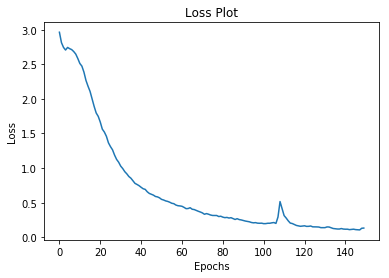

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

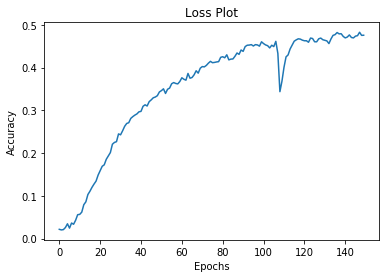

In [ ]:
plt.plot(train_accuracy_results)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Loss Plot')
plt.show()

# Evaluate

In [ ]:
def evaluate(img_tensor):
    hidden = [tf.zeros((1, units))] #?
    img_tensor=tf.convert_to_tensor(img_tensor)
    img_tensor=tf.expand_dims(img_tensor,0) #start?
    enc_out, enc_hidden = encoder(img_tensor, hidden)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    dec_hidden = enc_hidden #?
    
    result = ''

    for i in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += tokenizer.index_word[predicted_id] + ' '


        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [ ]:
for i in range(len(video_files)):
  print("Predicted :",evaluate(X_train[i]),end="")
  print(" || True",sent[i])

Predicted : that there's an interesting problem but they don't quite have the tools yet to discover them they spend all this time <end>  || True ['<start>', 'TO', 'SHOW', 'IT', 'TO', 'YOU', 'NOT', 'BECAUSE', 'I', 'WANT', 'TO', 'GIVE', 'YOU', 'THE', 'KIND', 'OF', 'STARBUCKS', 'TOUR', 'OF', 'HISTORIC', 'ENGLAND', 'BUT', '<end>']
Predicted : morning and the news has just broken about this satellite that's now orbiting the planet from a known location on the planet from a known location on the planet from a known location on the planet from a known location on the planet from a known location on the planet from a  || True ['<start>', 'BEFORE', 'THE', 'SPREAD', 'OF', 'COFFEE', 'AND', 'TEA', 'THROUGH', 'BRITISH', 'CULTURE', 'WHAT', 'PEOPLE', 'DRANK', 'BOTH', 'ELITE', 'AND', 'MASS', 'FOLKS', 'DRANK', '<end>']
Predicted : a lot of these values and it's just wonderful kind of tale of innovation and how it happens in unlikely <end>  || True ['<start>', 'DRINKING', 'ALL', 'DAY', 'AND', 'THEN', 'Y

In [ ]:
evaluate(X_train[20]) 

"forerunner on the expertise to think could we build a neonatal incubator that's built entirely out of automobile <end> "

In [ ]:
sent[20]

['<start>',
 'FORERUNNER',
 'ON',
 'THE',
 'STREET',
 'IN',
 'ALL',
 'THESE',
 'PLACES',
 'THEY',
 'SEEM',
 'TO',
 'HAVE',
 'THE',
 'EXPERTISE',
 'TO',
 'KEEP',
 'CARS',
 'WORKING',
 'SO',
 'THEY',
 'STARTED',
 'TO',
 'THINK',
 'COULD',
 'WE',
 'BUILD',
 'A',
 'NEONATAL',
 'INCUBATOR',
 "THAT'S",
 'BUILT',
 'ENTIRELY',
 'OUT',
 'OF',
 'AUTOMOBILE',
 '<end>']

In [ ]:
evaluate(X_train[5]) 

"spending a lot of time thinking about coffeehouses for the last five years because i've been kind of on this quest to investigate this <end> "

In [ ]:
sent[5]

['<start>',
 'SPENDING',
 'A',
 'LOT',
 'OF',
 'TIME',
 'THINKING',
 'ABOUT',
 'COFFEEHOUSES',
 'FOR',
 'THE',
 'LAST',
 'FIVE',
 'YEARS',
 'BECAUSE',
 "I'VE",
 'BEEN',
 'KIND',
 'OF',
 'ON',
 'THIS',
 'QUEST',
 'TO',
 'INVESTIGATE',
 'THIS',
 '<end>']

In [ ]:
!cp -r '/content/training_checkpoints' '/gdrive/My Drive/Hello Attention/Practice 4/CKPT'

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# loading
#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)'''import pickle

In [ ]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
tokenizer

In [ ]:
!cp -r '/content/tokenizer.pickle' '/gdrive/My Drive/Hello Attention/Practice 4/'

#Rough

In [ ]:
for epoch in range(2):
    start = time.time()
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
      print(batch)
      print(img_tensor[0][0][0][0])
      print(X_train[0][0][0][0])

0
tf.Tensor([0.654902  0.5882353 0.4509804], shape=(3,), dtype=float32)
[0.654902  0.5882353 0.4509804]
0
tf.Tensor([0.654902  0.5882353 0.4509804], shape=(3,), dtype=float32)
[0.654902  0.5882353 0.4509804]


In [ ]:
X_train[0].shape

(75, 100, 50, 3)

In [ ]:
tf.expand_dims([tokenizer.word_index['<start>']], 0)

array([[2]])

In [ ]:
max_length=6

In [ ]:
hidden = [tf.zeros((1, units))]
enc_out, enc_hidden = encoder(X_train[0], hidden)

In [ ]:
tf.convert_to_tensor(X_train[0][0][0][0])

<tf.Tensor: id=360999, shape=(3,), dtype=float32, numpy=array([0.654902 , 0.5882353, 0.4509804], dtype=float32)>

In [ ]:
evaluate(X_train[0])

'set white with <end> '

In [ ]:
sent

[['<start>', 'set', 'white', 'with', 'p', 'two', 'soon', '<end>'],
 ['<start>', 'place', 'red', 'in', 'a', 'zero', 'now', '<end>']]

In [ ]:
ypred = []
for i in range(32):
  ypred.append(evaluate(X_test[i]))
with open('ypred.txt', 'w') as f:
  print('\n'.join(ypred), file=f)
!cp 'ypred.txt' 'drive/My Drive/ypred.txt'

In [ ]:
y = []
for i in range(32):
  ypred.append(evaluate(X_test[i]))
with open('ypred.txt', 'w') as f:
  print('\n'.join(ypred), file=f)
!cp 'ypred.txt' 'drive/My Drive/ypred.txt'